# 文本分类实例-英文评论情感预测（Text Classification Example - English Comment Emotion Prediction）

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 数据读取和观察

In [2]:
# 使用pandas打开csv文件
data = pd.read_csv('./dataset/Tweets.csv')
# 查看数据
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# 分离评价内容和对应的情感标签
data = data[['airline_sentiment', 'text']]
# 查看数据信息
data.info()
# 查看是否有重复值
print("Rebeated rows: ", data.duplicated().sum())
# 除去数据中的重复值
data.drop_duplicates(inplace=True)
# 查看重复值是否去除
print("Rebeated rows after drop: ", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB
Rebeated rows:  188
Rebeated rows after drop:  0


In [4]:
# 查看情感标签
print(data.airline_sentiment.unique())
# 查看情感标签的分布是否均衡
data.airline_sentiment.value_counts()

['neutral' 'positive' 'negative']


negative    9087
neutral     3067
positive    2298
Name: airline_sentiment, dtype: int64

In [5]:
# 查看当前处理后的数据
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [6]:
# 标签的处理
# 将情感标签转换为数字
data['review'] = pd.factorize(data.airline_sentiment)[0]
# 删除情感标签列
del data['airline_sentiment']
# 查看当前处理后的数据
data.head()

,text,review
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [7]:
# 文本的处理
import re
# 定义一个正则表达式，用于匹配文本中的单词和标点符号
token = re.compile('[A-Za-z]+|[!?,.()]')
# 文本处理函数
def reg_text(text):
    new_text = token.findall(text)
    new_text = [word.lower() for word in new_text]
    return new_text
# 处理文本
data['text'] = data.text.apply(reg_text)
# 查看处理后的文本
data.head()

,text,review
0,"[virginamerica, what, dhepburn, said, .]",0
1,"[virginamerica, plus, you, ve, added, commerci...",1
2,"[virginamerica, i, didn, t, today, ., ., ., mu...",0
3,"[virginamerica, it, s, really, aggressive, to,...",2
4,"[virginamerica, and, it, s, a, really, big, ba...",2


## 创建词表（vocab）

In [8]:
# 初始化空集合
word_set = set()
# 遍历数据集中的所有文本，将每个单词添加到集合中
for text in data.text:
    for word in text:
        word_set.add(word)
# 打印集合的大小，即词汇表的大小
max_word = len(word_set) + 1
print(max_word)

13668


In [9]:
# 将集合转换为列表
word_list = list(word_set)
# 查找单词在列表中的索引
word_list.index('spending')

10075

In [10]:
# 从列表构建字典
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)
word_index

{'hid': 1,
 'hated': 2,
 'involve': 3,
 'yr': 4,
 'usatodaytravel': 5,
 'bundle': 6,
 'rated': 7,
 'threehourslate': 8,
 'mypompanobeach': 9,
 'evennotified': 10,
 'pseudo': 11,
 'extraordinaire': 12,
 'offloading': 13,
 'comms': 14,
 'ufyxxkisa': 15,
 'decorum': 16,
 'tug': 17,
 'whyairtravelsucks': 18,
 'whenever': 19,
 'carmen': 20,
 'rising': 21,
 'garcia': 22,
 'reality': 23,
 'iidrblnoox': 24,
 'flypdx': 25,
 'jockeying': 26,
 'lpalumbo': 27,
 'tnyctrb': 28,
 'compare': 29,
 'reinstate': 30,
 'century': 31,
 'hellobrittney': 32,
 'directly': 33,
 'now': 34,
 'orbitz': 35,
 'avrtowtyzk': 36,
 'up': 37,
 'hunt': 38,
 'rocked': 39,
 'glance': 40,
 'frontier': 41,
 'maxfitgirl': 42,
 'unproductive': 43,
 'quickie': 44,
 'whoooo': 45,
 'smoothest': 46,
 'bestinclasssocial': 47,
 'issued': 48,
 'texting': 49,
 'flyingitforward': 50,
 'beta': 51,
 'kevolt': 52,
 'every': 53,
 'living': 54,
 'hmcrjchb': 55,
 '!': 56,
 'filmcrew': 57,
 'favoriteairline': 58,
 'synch': 59,
 'nyvv': 60,
 'u

## 文本数据预处理

In [11]:
# 查看数据文本
data.text

0                 [virginamerica, what, dhepburn, said, .]
1        [virginamerica, plus, you, ve, added, commerci...
2        [virginamerica, i, didn, t, today, ., ., ., mu...
3        [virginamerica, it, s, really, aggressive, to,...
4        [virginamerica, and, it, s, a, really, big, ba...
                               ...                        
14635    [americanair, thank, you, we, got, on, a, diff...
14636    [americanair, leaving, over, minutes, late, fl...
14637    [americanair, please, bring, american, airline...
14638    [americanair, you, have, my, money, ,, you, ch...
14639    [americanair, we, have, ppl, so, we, need, kno...
Name: text, Length: 14452, dtype: object

In [12]:
# 将单词使用词表进行编码
text = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])
# 查看编码后的数据
text

0                            [77, 5705, 4821, 9826, 11651]
1        [77, 3489, 975, 11398, 4103, 2825, 2671, 10667...
2        [77, 1945, 88, 13362, 3045, 11651, 11651, 1165...
3        [77, 4182, 7530, 11789, 5607, 2671, 1785, 5152...
4        [77, 3343, 4182, 7530, 4200, 11789, 407, 1707,...
                               ...                        
14635    [9084, 2525, 975, 7395, 12867, 3391, 4200, 608...
14636    [9084, 2817, 12138, 11555, 4765, 781, 11651, 8...
14637           [9084, 3001, 296, 3392, 5453, 2671, 10715]
14638    [9084, 975, 817, 9690, 11742, 627, 975, 187, 9...
14639    [9084, 7395, 817, 1826, 8065, 7395, 4647, 2251...
Name: text, Length: 14452, dtype: object

In [13]:
# 获取最大评论长度
maxlen = max(len(x) for x in text)
print("Max length: ", maxlen)
# 将评论填充到最大长度
pad_text = [l + (maxlen-len(l))*[0] for l in text]
# 转化为numpy数组
pad_text = np.array(pad_text)
# 查看填充后的数据形状
print("pad_text.shape: ", pad_text.shape)
# 查看填充后的数据
pad_text[:5]

Max length:  40
pad_text.shape:  (14452, 40)


array([[   77,  5705,  4821,  9826, 11651,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   77,  3489,   975, 11398,  4103,  2825,  2671, 10667,  7595,
        11651, 11651, 11651,  1502, 11651,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   77,  1945,    88, 13362,  3045, 11651, 11651, 11651,  4613,
         3007,  1945,  4647,  2671,  4107,  3234,  2630,    56,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   77,  4182,  7530, 11789,  

## 标签数据预处理

In [14]:
# 获取标签数据
labels = data.review.values
# 查看标签数据形状
print("labels.shape: ", labels.shape)

labels.shape:  (14452,)


## 划分数据集

In [15]:
from sklearn.model_selection import train_test_split
# 划分数据集，使用默认的划分比例7.5：2.5
x_train, x_test, y_train, y_test = train_test_split(pad_text, labels)
x_train.shape, x_test.shape, y_train.shape

((10839, 40), (3613, 40), (10839,))

## 创建Dataset

In [16]:
# 定义一个自定义的数据集类
class Tweets_dataset(torch.utils.data.Dataset):
    def __init__(self, text_list, label_list):
        self.text_list = text_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        text = torch.LongTensor(self.text_list[index])
        label = self.label_list[index]
        return text, label

    def __len__(self):
        return len(self.text_list)

In [17]:
# 创建训练集和测试集
train_ds = Tweets_dataset(x_train, y_train)
test_ds = Tweets_dataset(x_test, y_test)

In [18]:
# 创建数据加载器
BTACH_SIZE = 32

train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

## 模型构建

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Embedding 把文本映射为一个密集向量，将每一个单词映射为一个100维的向量
        self.em = nn.Embedding(max_word, 100)   # 输出：batch*maxlen*100
        self.fc1 = nn.Linear(maxlen*100, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.em(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# 参数整理
model = Net()
learn_rate = 0.001
epochs = 20
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        y = y.long()      # 将标签转换为long类型
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl:  # 遍历数据集
            y = y.long()      # 将标签转换为long类型
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.8031, Train Acc: 66.83%, Test Loss: 0.7092, Test Acc: 69.89%
Epoch: 1, Train Loss: 0.5918, Train Acc: 75.27%, Test Loss: 0.7032, Test Acc: 69.53%
Epoch: 2, Train Loss: 0.4235, Train Acc: 82.61%, Test Loss: 0.7862, Test Acc: 71.30%
Epoch: 3, Train Loss: 0.2919, Train Acc: 88.11%, Test Loss: 0.8152, Test Acc: 72.60%
Epoch: 4, Train Loss: 0.1999, Train Acc: 92.37%, Test Loss: 0.9307, Test Acc: 71.35%
Epoch: 5, Train Loss: 0.1440, Train Acc: 94.40%, Test Loss: 1.1854, Test Acc: 72.29%
Epoch: 6, Train Loss: 0.1106, Train Acc: 96.03%, Test Loss: 1.2654, Test Acc: 73.12%
Epoch: 7, Train Loss: 0.0824, Train Acc: 97.17%, Test Loss: 1.3913, Test Acc: 72.93%
Epoch: 8, Train Loss: 0.0628, Train Acc: 98.03%, Test Loss: 1.5643, Test Acc: 73.07%
Epoch: 9, Train Loss: 0.0525, Train Acc: 98.37%, Test Loss: 1.5449, Test Acc: 73.65%
Epoch: 10, Train Loss: 0.0442, Train Acc: 98.61%, Test Loss: 1.5982, Test Acc: 71.77%
Epoch: 11, Train Loss: 0.0489, Train Acc: 98.55%, Test Loss: 1.6

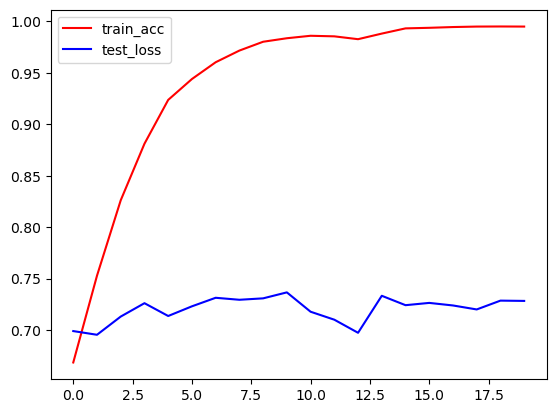

In [21]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

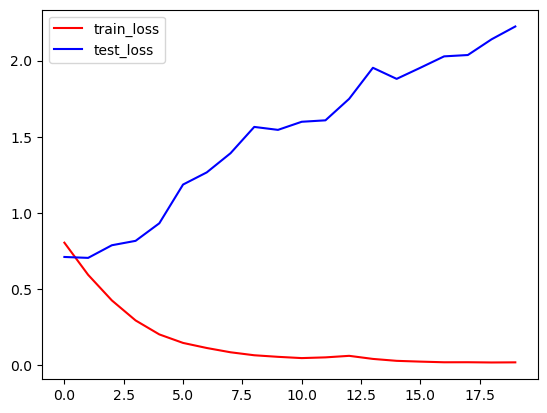

In [22]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()

# 使用LSTM

In [23]:

class LSTM_Net(nn.Module):
    def __init__(self):
        super(LSTM_Net, self).__init__()
        self.em = nn.Embedding(max_word, 100)   # batch*maxlen*100
        self.lstm = nn.LSTM(100, 200, batch_first=True)
        self.fc1 = nn.Linear(200, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.em(x)
        x, _ = self.lstm(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x

In [ ]:
# 参数整理
model = LSTM_Net()
learn_rate = 0.001
epochs = 20
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        y = y.long()      # 将标签转换为long类型
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl:  # 遍历数据集
            y = y.long()      # 将标签转换为long类型
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.9182, Train Acc: 62.86%, Test Loss: 0.9171, Test Acc: 62.94%
Epoch: 1, Train Loss: 0.9158, Train Acc: 62.86%, Test Loss: 0.9217, Test Acc: 62.94%
Epoch: 2, Train Loss: 0.9154, Train Acc: 62.87%, Test Loss: 0.9153, Test Acc: 62.94%
Epoch: 3, Train Loss: 0.9147, Train Acc: 62.87%, Test Loss: 0.9212, Test Acc: 62.94%
Epoch: 4, Train Loss: 0.9140, Train Acc: 62.87%, Test Loss: 0.9152, Test Acc: 62.94%
Epoch: 5, Train Loss: 0.9142, Train Acc: 62.87%, Test Loss: 0.9171, Test Acc: 62.94%
Epoch: 6, Train Loss: 0.9141, Train Acc: 62.87%, Test Loss: 0.9167, Test Acc: 62.94%
Epoch: 7, Train Loss: 0.8833, Train Acc: 62.86%, Test Loss: 0.8547, Test Acc: 62.94%
Epoch: 8, Train Loss: 0.8427, Train Acc: 63.34%, Test Loss: 0.8307, Test Acc: 62.94%
Epoch: 9, Train Loss: 0.8127, Train Acc: 64.88%, Test Loss: 0.8095, Test Acc: 64.49%
Epoch: 10, Train Loss: 0.7569, Train Acc: 67.30%, Test Loss: 0.7932, Test Acc: 67.23%
Epoch: 11, Train Loss: 0.6707, Train Acc: 71.53%, Test Loss: 0.7

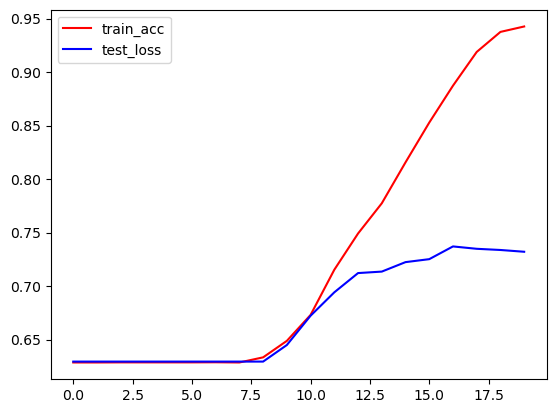

In [ ]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

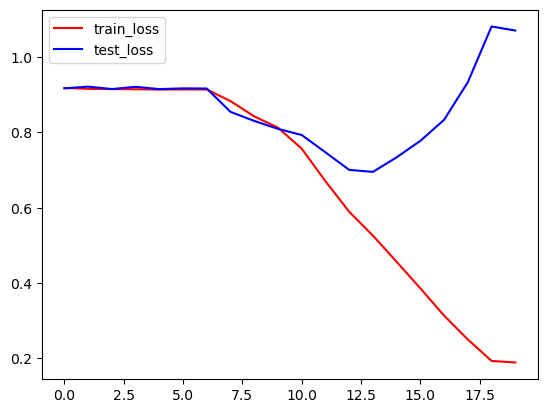

In [ ]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()